# Topic Modeling for E-commerce Reviews using BERTopic

In [1]:
import pandas as pd
import yaml
from dagshub.streaming import install_hooks

## 1. Import and Clean data

In [3]:
def read_yaml(namefile='src/config.yaml'):
    f = open(namefile,'rb')
    diz = yaml.load(f, Loader=yaml.FullLoader)
    f.close()
    return diz

In [4]:
def clean_data(file_path):
    df = pd.read_csv(file_path,index_col=0)
    df.dropna(subset=['Review Text'],inplace=True)
    return df

In [5]:
params = read_yaml()

In [6]:
df = clean_data(params['raw_data_path'])
df_young = df[df.Age<=36]
df.to_csv(params['all_path'])
df_young.to_csv(params['young_path'])

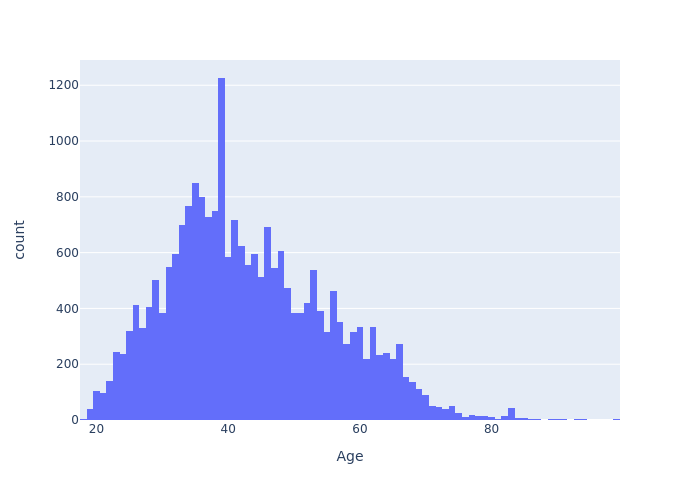

In [7]:
import plotly.express as px
fig_age = px.histogram(df, x = 'Age')
fig_age.show("png")

## 2. Train BERTopic model

In [6]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
import nltk.stem

/home/eugenia/topic-modeling-reviews/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugenia/topic-modeling-reviews/venv/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [10]:
import pickle
from dagshub.streaming import install_hooks

In [8]:
english_stemmer = nltk.stem.SnowballStemmer('english') 
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

def train_bert(docs,model_path):
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Clustering model: See [2] for more details
    cluster_model = HDBSCAN(min_cluster_size = 15, 
                            metric = 'euclidean', 
                            cluster_selection_method = 'eom', 
                            prediction_data = True)
    
    #Explicitly define, use, and adjust the ClassTfidfTransformer with new parameters, 
    #bm25_weighting and reduce_frequent_words, to potentially improve the topic representation
    ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)                         
    #vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))
    vectorizer_model = StemmedCountVectorizer(analyzer="word",stop_words="english", ngram_range=(1, 2))

    # BERTopic model
    topic_model = BERTopic(embedding_model = embedding_model,
                           hdbscan_model = cluster_model,
                           ctfidf_model=ctfidf_model,
                           vectorizer_model=vectorizer_model,
                           language="english")

    # Fit the model on a corpus
    topics, probs = topic_model.fit_transform(docs)
    topic_model.save(model_path)
    return topic_model

def load_bert(model_path):
    topic_model = BERTopic.load(model_path)
    return topic_model

In [12]:
# Install hooks
install_hooks(repo_url='https://dagshub.com/eugenia.anello/topic-modeling-reviews')

In [13]:
# remove data from local PC: rm -r data
print('Load data from remote!')
with open(params['young_path']) as pd_file:
    df_young = pd.read_csv(pd_file,index_col=0)
pd_file.close()

Load data from remote!


In [14]:
docs = df_young['Review Text'].values.tolist() 
print(docs[0])
with open('docs.pkl', 'wb') as f:
    pickle.dump(docs, f)
f.close()

Absolutely wonderful - silky and sexy and comfortable


In [9]:
print('Start training!')
if params['model_already_trained']==False:
    topic_model = train_bert(docs,params['model_path'])
else:
    topic_model = load_bert(params['model_path'])
print('End training!')
print(topic_model.get_topic_freq().head())

Start training!
End training!
   Topic  Count
0     -1   2270
1      0    779
2      1    488
3      2    488
4      3    381


In [10]:
freq_df = topic_model.get_topic_info()
print("Number of topics: {}".format( len(freq_df)))
freq_df['Percentage'] = round(freq_df['Count']/freq_df['Count'].sum() * 100,2)
freq_df = freq_df.iloc[:,[0,1,3,2]]
freq_df.head()

Number of topics: 46


,Topic,Count,Percentage,Name
0,-1,2270,30.34,-1_dress_size_look_small
1,0,779,10.41,0_pant_jean_leg_pair
2,1,488,6.52,1_shirt_love shirt_soft_small
3,2,488,6.52,2_dress_love dress_like_fabric
4,3,381,5.09,3_sweater_love sweat_soft_look


In [11]:
def load_bert(model_path):
    model = BERTopic.load(model_path)
    return model

In [12]:
topic_model = load_bert(params['model_path'])

## 3. Track Experiments with MLflow

1. Intertopic Distance Map
2. Topic-Terms Bar Charts
3. Document 2D Projection
4. Topics dendrogram
5. Heatmap

In [13]:
import plotly.io as pio
pio.renderers.default='iframe'

In [18]:
fig1 = topic_model.visualize_topics()
fig1.show()

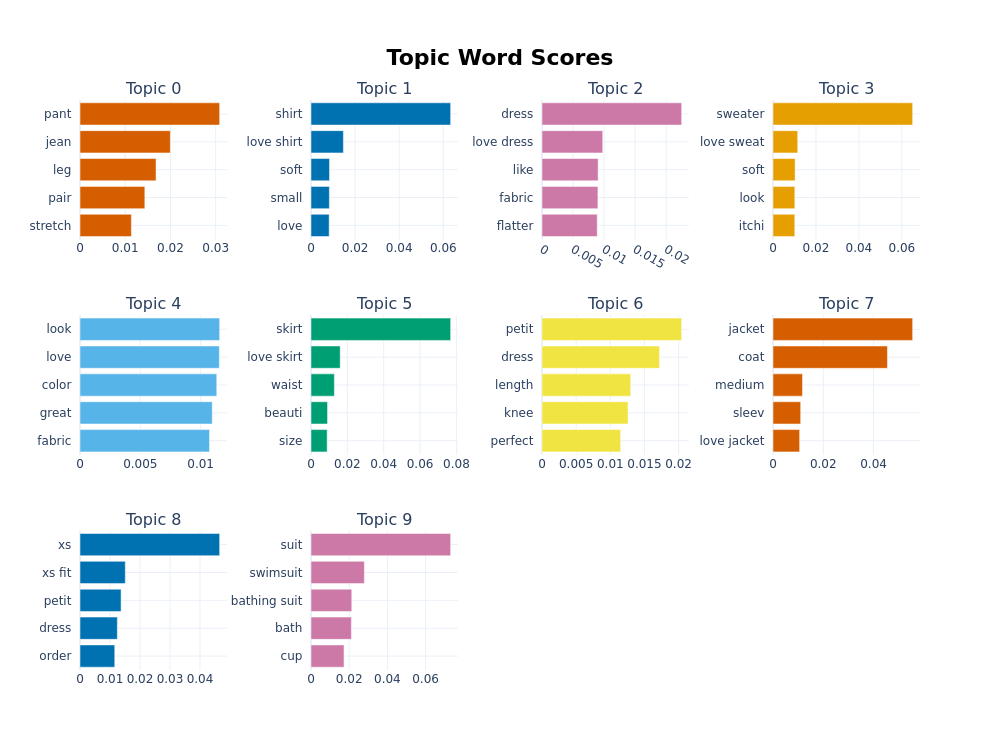

In [21]:
# Save topic-terms barcharts as HTML file
fig2 = topic_model.visualize_barchart(top_n_topics = 10)
fig2.show("png")

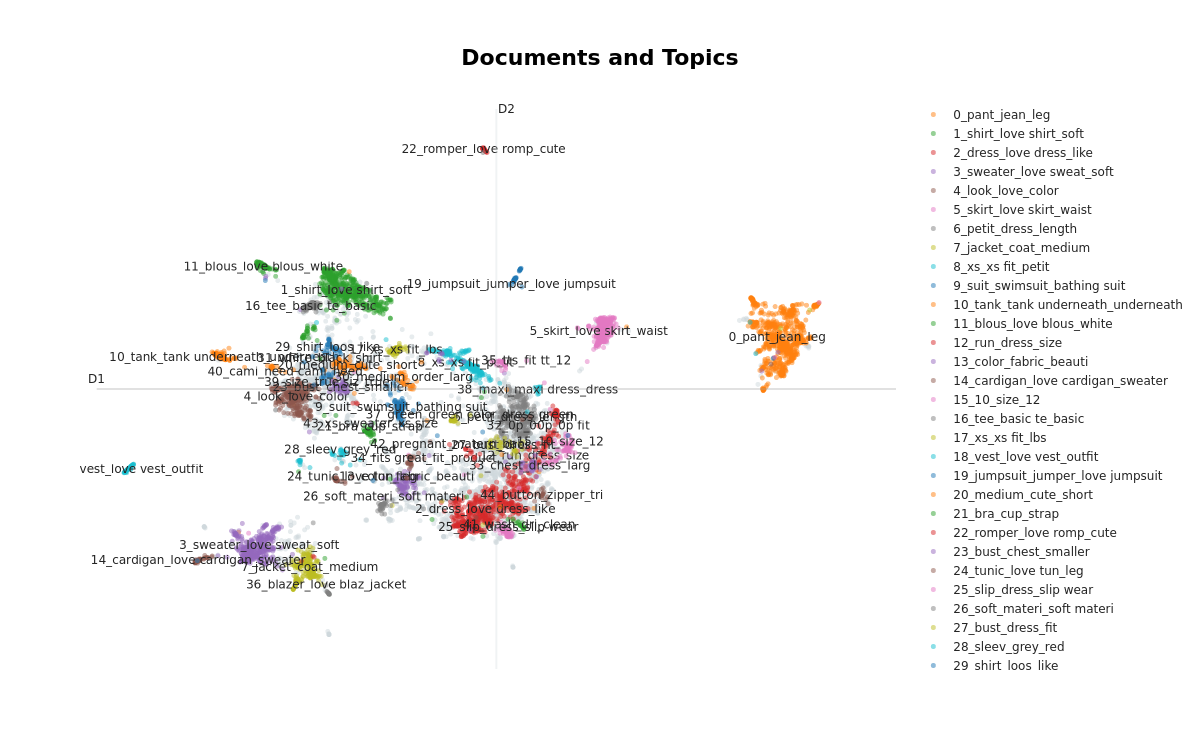

In [22]:
# Save documents projection as HTML file
fig3 = topic_model.visualize_documents(docs)
fig3.show("png")

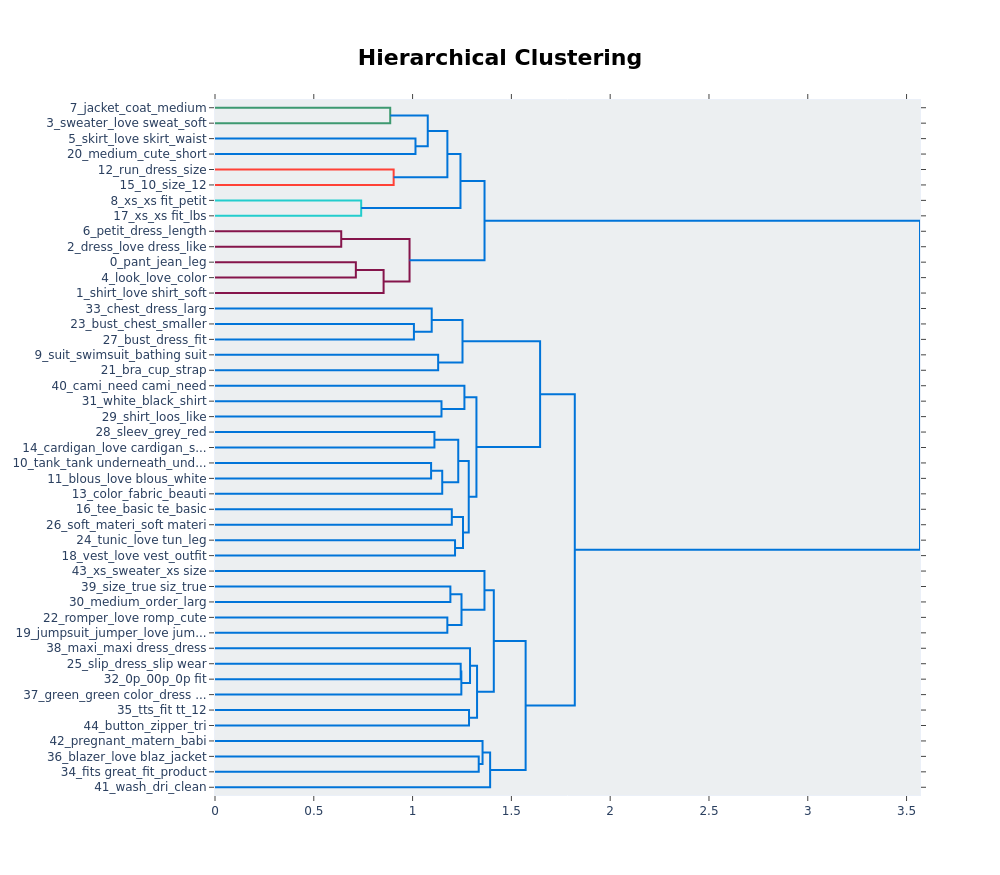

In [23]:
# Save topics dendrogram as HTML file
fig4 = topic_model.visualize_hierarchy()
fig4.show("png")

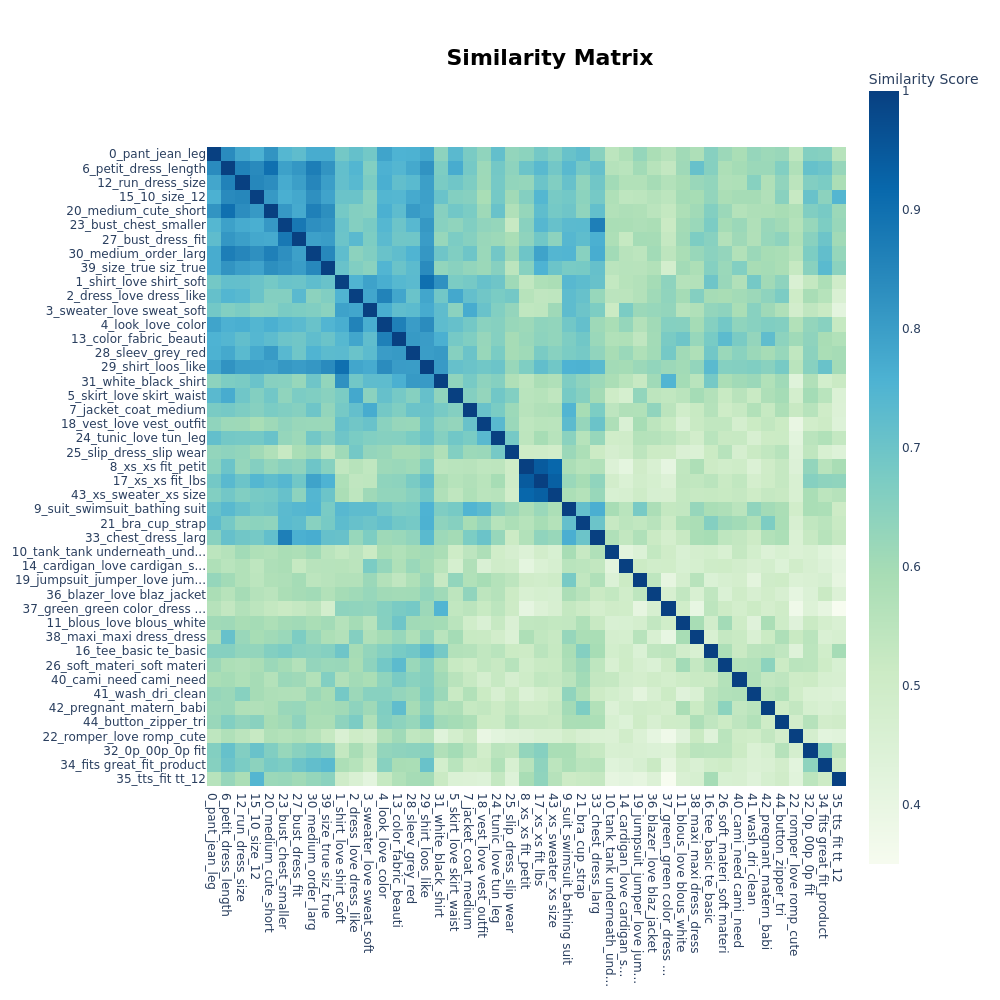

In [24]:
fig5 = topic_model.visualize_heatmap(n_clusters=10, width=1000, height=1000)
fig5.show("png")

In [ ]:
fig1.write_html("output/intertopic_dist_map.html")
fig2.write_html("output/barchart.html")
fig3.write_html("output/projections.html")
fig4.write_html("output/hierarchy.html")
fig5.write_html("output/heatmap.html")

In [ ]:
import os
import mlflow
from dagshub import dagshub_logger

In [ ]:
l_html = os.listdir('output') 
print(l_html) 

In [ ]:
# l_html.remove('docs.pkl')
# l_html.remove('.gitignore')

In [ ]:
mlflow.set_tracking_uri(params['mlflow_url'])
os.environ['MLFLOW_TRACKING_USERNAME'] = params['MLFLOW_TRACKING_USERNAME']
os.environ['MLFLOW_TRACKING_PASSWORD'] = params['MLFLOW_TRACKING_PASSWORD']

In [ ]:
_ = mlflow.create_experiment("topic_modeling")

with mlflow.start_run():
    with dagshub_logger() as logger:
        logger.log_hyperparams({"model_name": 'BERTopic'})

    for html_path in l_html:
        mlflow.log_artifact('output/'+html_path)